<p style="font-size: 40px; font-weight: bold; text-align: center;">HousePrice prediction project</p>

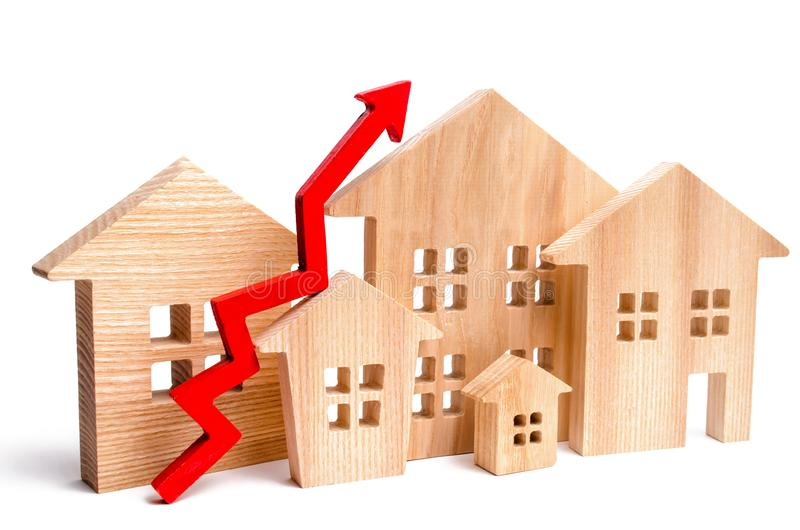

The project aimed at using statistical and machine learning algorithms to analyze and forecast the prices of houses. The project involves collecting data on housing prices and relevant features, such as location, size, age, and amenities, and training models to make predictions based on that data. The goal is to produce accurate predictions that can be used by real estate agents, developers, and buyers to make informed decisions.

## Import libraries

In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Import model selection and evaluation functions
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score
)
from math import sqrt

# Import preprocessing libraries
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer

# Import feature engineering libraries
from feature_engine.discretisation import (
    EqualFrequencyDiscretiser, 
    EqualWidthDiscretiser
)
from feature_engine.selection import (
    SmartCorrelatedSelection, 
    DropConstantFeatures
)
from feature_engine.imputation import (
    ArbitraryNumberImputer, 
    EndTailImputer, 
    CategoricalImputer,
    MeanMedianImputer, 
    RandomSampleImputer
)
from feature_engine.encoding import (
    CountFrequencyEncoder, 
    OneHotEncoder, 
    OrdinalEncoder,
    RareLabelEncoder
) 

# Import machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

# Additional feature engineering libraries
from feature_engine.selection import (
    DropConstantFeatures, 
    DropDuplicateFeatures
)
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Others
from typing import Tuple

# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Functions

In [21]:
def correlation_filter(df, df_target, tolerance):  
    '''
    This function filters correlated variables from a given 
    dataset by taking in a dataframe 'df', a target dataframe 
    'df_target' and a tolerance level 'tolerance' as inputs, 
    creating a correlation matrix, iterating through the columns, 
    filtering out correlated variables that meet a certain criteria,
    creating a drop_list of these variables, and returning it.
    '''
    # create a correlation matrix using the input dataframe 'df' and target dataframe 'df_target'
    corr_matrix = pd.concat([df, df_target], axis = 1).corr()
    # create an empty list and dataframe to store filtered variables
    total_list = []
    total_df = pd.DataFrame()
    # iterate through the columns of the correlation matrix
    for i in list(corr_matrix.columns):
        # filter variables with a correlation coefficient less than the input tolerance and not equal to 1
        adding_df = corr_matrix[(abs(corr_matrix[i]) < tolerance) &
                                (corr_matrix[i]!= 1.0)][df_target.name]
        # if no variables meet the filtering criteria, skip
        if adding_df.empty:
            pass
        # otherwise, append the filtered variables to the total list
        else:
            total_list.append(adding_df)
    # create a temporary dataframe of the filtered variables and round the values to 2 decimal places
    temporary_df = pd.DataFrame(total_list).round(2)
    # create a list of the variables to be dropped by getting the last row of the temporary dataframe,
    # dropping any NaN values, and getting the index of the remaining variables
    drop_list = list(temporary_df.iloc[-1].dropna().index)
    # return the list of variables to be dropped
    return drop_list

In [22]:
def dominant_cat_analyser(train, train_target, searching_type, plot):  
    '''
    This function identifies categorical
    variables in which there is a dominant label.
    '''
    # Initialize an empty list to store the dominant categorical columns
    dominant_cat_list = []
    # Create an empty dataframe to store the relative frequencies of unique values in each column
    test = pd.DataFrame()
    # Get the relative frequencies of unique values in each column
    tmp_df = show_unique_labels(train)
    # Iterate over the categorical columns
    for i in categorical_numerical_splitter(train)[0]: 
        # Add the relative frequencies of unique values to the test dataframe
        test[i] = tmp_df[i+'_mean']
        # Check the searching_type input is valid
        if searching_type not in ['hard', 'light']:
            raise ValueError("Invalid searching_type input, it should be either 'hard' or 'light'")
        # Check if the column is a dominant category
        if searching_type == 'hard':
            if test[i][0] > 0.85:
                dominant_cat_list.append(i)
        elif searching_type == 'light':
            if (test[i][:2].sum() > 0.8) and (test[i][0] < 0.5):
                dominant_cat_list.append(i)
    # check if the plot input is valid
    if plot not in ['yes', 'no']:
        raise ValueError("Invalid plot input, it should be either 'yes' or 'no'")
    # Plot the dominant categories if plot input is 'yes'
    if plot == 'yes':
        for var in dominant_cat_list:
            categorical_var_analyser(train,train_target,var)
    # Return the list of dominant categories
    return dominant_cat_list

In [23]:
def drop_useless_col(df: pd.DataFrame, add_drop: list = []) -> pd.DataFrame:
    '''
    This function takes in a pandas dataframe and a list of column
    names and drops the columns in the dataframe that have
    more than 45% missing values or are listed in add_drop.
    
    Parameters:
        df : DataFrame, containing the data
        add_drop : list, containing the additional column names to be dropped

    Return:
        df : DataFrame, modified dataframe after dropping the useless columns
    '''
    # Create a list of columns that have more than 45% missing values
    drop_list = [var for var in df.columns if df[var].isnull().mean()>0.45]
    
    # Add the columns in add_drop to drop_list
    drop_list += add_drop
    
    # Drop the columns in drop_list from the dataframe
    if add_drop == []:
        df = df.drop(columns = drop_list)
    else:
        df = df.drop(columns = drop_list + add_drop)
    
    # Print a message indicating which columns were dropped
    if drop_list != []:
        print('Dropped : ',drop_list)
        print('='*50)
    else:
        print('Nothing to drop!')
        
    # Return the modified dataframe
    return df

In [24]:
def show_unique_labels(df: pd.DataFrame) -> pd.DataFrame:
    '''
    This function sorts variables by the number of 
    labels and displays their distribution 
    relative to all rows in the column.
    
    Parameters:
        df : DataFrame, containing the data
    
    Return:
        unique_labels : DataFrame, containing unique labels and relative frequencies
    '''
    # Get the column names of categorical columns from the function `categorical_numerical_splitter`
    categorical_cols = categorical_numerical_splitter(df)[0]
    # Create a dictionary with column names as keys and number of unique values as values
    len_dict = {col: len(df[col].unique()) for col in categorical_cols}
    # Sort the column names based on the number of unique values in descending order
    sorted_cols = sorted(len_dict, key=len_dict.get, reverse=True)
    # Create an empty dataframe to store the unique labels and relative frequencies
    unique_labels = pd.DataFrame()
    # Iterate over the sorted column names
    for col in sorted_cols:
        # Add the unique labels as a column in the dataframe
        unique_labels[col] = pd.DataFrame(df[col].value_counts().index)
        # Add the relative frequencies of the unique labels as a column in the dataframe
        unique_labels[col+'_mean'] = pd.Series((df[col].value_counts()/len(df[col])).values)
    # Return the dataframe
    return unique_labels

In [25]:
def categorical_numerical_splitter(df) -> Tuple[list,list]:
    '''
    This function separates variables 
    into numerical and categorical columns.
    
    Parameters:
        df : DataFrame, containing the data
        
    Return:
        cat: list, containing categorical column names.
        num: list, containing numerical column names.
    '''
    # Select the columns with dtype 'object' and convert them to a list
    cat = df.select_dtypes(include='object').columns.tolist()
    # Select all columns except the ones with dtype 'object' and convert them to a list
    num = df.select_dtypes(exclude='object').columns.tolist()
    # Return the lists of categorical and numerical column names
    return cat, num

In [26]:
def create_param_grid(algorithm_name:str, parameters:dict)-> dict:
    '''
    Create a parameter grid for grid search 
    using a dictionary comprehension
    
    Parameters:
        algorithm_name: str, name of the algorithm
        parameters: dict, containing the parameter name and values
    
    Return:
        param_grid: dict, containing the parameter grid
    '''
    # using a dictionary comprehension instead of a for loop
    param_grid = {f"{algorithm_name}__{param}": val for param, val in parameters.items()}
    return param_grid

In [27]:
def create_model(algorithm_name:str, algorithm) -> Pipeline:
    '''
    Create a model using the given algorithm_name and algorithm. 
    The model includes a pipeline of various preprocessing steps and the final algorithm.
    
    Parameters:
        algorithm_name (str): Name of the algorithm to be used.
        algorithm: The algorithm to be used.
    
    Returns:
        A pipeline of preprocessing steps and the final algorithm.
    '''
    # Create a pipeline object
    pipe = Pipeline([
        # Imputation step for numerical variables
        ('imputation_numerics', MeanMedianImputer(variables=num_list)),
        # Imputation step for categorical variables
        ('imputation_categories', CategoricalImputer(imputation_method='missing',variables=cat_list)),
        # Discretization step for numerical variables
        ('discretiser_numerics', EqualFrequencyDiscretiser(variables=num_list)),
        # Encoding step for rare labels in categorical variables
        ('encoder_rarelabel', RareLabelEncoder(tol=0.1, n_categories=2, variables=cat_list)),
        # Encoding step for categorical variables
        ('encoder_categories', CountFrequencyEncoder(variables=cat_list)),
        # Normalize step for all dataframe
        ('SC',StandardScaler(with_mean=False)),
        # Step to fit the input algorithm
        (algorithm_name, algorithm)
    ])
    return pipe

In [28]:
def registrate_score(container, algorithm_name, train_score, train_score_MAE, test_score, test_score_MAE, grid_search):
    # Use the correct variable name for algorithm_name
    container['algorithm_name'].append(algorithm_name)
    # Append the train score to the container
    container['train_score_r2'].append(train_score)
    # Append the train score mean absolute error to the container
    container['train_score_MAE'].append(train_score_MAE)
    # Append the test score to the container
    container['test_score_r2'].append(test_score)
    # Append the test score mean absolute error to the container
    container['test_score_MAE'].append(test_score_MAE)
    # Append the best parameters found by grid search to the container
    container['best_params'].append(grid_search.best_params_)

In [215]:
def eval_plot(scores:list, target:str)-> None:
    """
    Plot a barplot to compare train and test scores of algorithms
    
    Parameters:
        scores (dict): a dictionary that contains the scores and algorithm names
        target (str): the main target score to compare, either 'train_score' or 'test_score'
    
    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(16,5))
    
    data = pd.DataFrame(scores).sort_values(by=target,ascending=False)
    
    # map target score to secondary target score
    score_map = {
        'train_score_r2': 'test_score_r2',
        'test_score_r2': 'train_score_r2',
        'train_score_MAE': 'test_score_MAE',
        'test_score_MAE': 'train_score_MAE'
    }
    sec_target = score_map[target]
    
    # plot the main target score
    sns.barplot(
        data=data, 
        x=target, 
        y='algorithm_name', 
        palette='Paired', 
        ax=ax
    )
    
    # plot the secondary target score
    sns.barplot(
        data=data,
        x=sec_target,
        y='algorithm_name',
        palette='Paired', 
        alpha=0.2,
        ax=ax
    )
    
    # set plot title and formatting
    plt.title(f'{target.capitalize().replace("_", " ")} Metric Plot', fontsize=20)
    plt.grid(axis='x')
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.show()

## Loading dataset

In [29]:
# Setting options to see all columns in dataset
pd.set_option('display.max_columns',None)

# Reading csv file
data = pd.read_csv('houseprice.csv')

In [30]:
data['HouseAge'] = data['YrSold'] - data['YearBuilt']
data['RemodHouse'] = data['YrSold'] - data['YearRemodAdd']
data['GarageAge'] = data['YrSold'] - data['GarageYrBlt']
data.replace({'MoSold': {
    1: 'winter', 2: 'winter', 12: 'winter', 
    3: 'spring', 4: 'spring', 5: 'spring', 
    6: 'summer', 7: 'summer', 8: 'summer', 
    9: 'autumn', 10:'autumn', 11: 'autumn'
}},inplace=True)
data = data.drop(['YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold', 'GarageYrBlt'], axis = 1)

## Feature engineering

In [31]:
X_train,X_test,y_train,y_test = train_test_split(
    data.drop(columns='SalePrice'),
    data.SalePrice,
    test_size=0.3,
    random_state=0
)
X_train.shape,X_test.shape

((1022, 78), (438, 78))

In [32]:
# Defind useless columns by multicollinearity and missing indicator.
multicollinearity_list = ['1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'GarageArea', 'GarageAge']

# Defind weak correlation features
correlation_drop_list = correlation_filter(X_train,y_train, 0.3)

# Defind dominant features
dominant_features_list = dominant_cat_analyser(X_train, y_train, 'hard', 'no')

# Dropping defined columns
print('Train')
X_train = drop_useless_col(X_train,dominant_features_list + correlation_drop_list + multicollinearity_list)
print('Test')
X_test = drop_useless_col(X_test,dominant_features_list + correlation_drop_list + multicollinearity_list)

Train
Dropped :  ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'Id', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'GarageArea', 'GarageAge']
Test
Dropped :  ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'Low

## Pipelines with Grid-Search CV

In [33]:
# Split X_train into categorical and numerical variables
cat_list, num_list = categorical_numerical_splitter(X_train)

In [34]:
# This is a dictionary that will store the evaluation results of different machine learning algorithms
# It has the following keys:
evaluating_dict = {
    'algorithm_name':[], # Stores the name of the algorithm
    'train_score_r2':[], # Stores the training score of the algorithm
    'train_score_MAE':[], # Stores the training score of the algorithm in terms of mean absolute error
    'test_score_r2':[], # Stores the testing score of the algorithm
    'test_score_MAE':[], # Stores the testing score of the algorithm in terms of mean absolute error
    'best_params':[] # Stores the best parameters of the algorithm obtained through hyperparameter tuning
}

In [35]:
# This dictionary contains instances of various machine learning algorithms
algorithm_dict = {
    'GradientBoostingRegressor':GradientBoostingRegressor(),
    'DecisionTreeRegressor':DecisionTreeRegressor(),
    'RandomForestRegressor':RandomForestRegressor(),
    'KNeighborsRegressor':KNeighborsRegressor(),
    'XGBRegressor':XGBRegressor(),
    'SVR':SVR(),
}

In [36]:
# Define a dictionary containing hyperparameters for each algorithm
param_dict = {
    'GradientBoostingRegressor': {
        'n_estimators': [20, 50, 100],  # The number of trees in the forest
        'max_depth': [2, 4, 6],  # The maximum depth of the tree
        'min_samples_leaf': [1, 2, 4], # The minimum number of samples required to be at a leaf node
        'min_samples_split': [2, 4, 6],  # The minimum number of samples required to split an internal node
        'learning_rate': [0.1, 0.01, 0.001],  # The step size shrinkage used in update to prevents overfitting
    },

    'DecisionTreeRegressor': {
        'max_depth': [2, 4, 6],  # The maximum depth of the tree
        'min_samples_leaf': [1, 2, 5],  # The minimum number of samples required to be at a leaf node
        'min_samples_split': [2, 4, 6], # The minimum number of samples required to split an internal node
        'criterion': ['squared_error', 'absolute_error']  # The function to measure the quality of a split.
    },
    'RandomForestRegressor': {
        'n_estimators': [20, 50, 100], # The number of trees in the forest
        'max_depth': [2, 4, 6], # The maximum depth of the tree
        'min_samples_leaf': [1, 2, 5], # The minimum number of samples required to be at a leaf node
        'min_samples_split': [2, 4, 6], # The minimum number of samples required to split an internal node
        'criterion': ['squared_error','absolute_error'] # The function to measure the quality of a split
    },

    'KNeighborsRegressor': {
        'n_neighbors': [1, 3, 5],  # Number of neighbors to use by default for kneighbors queries
        'weights': ['uniform', 'distance'],  # weight function used in prediction
        'p': [1, 2]  # Power parameter for the Minkowski metric
    },
    'XGBRegressor': {
        'max_depth': [2, 4, 6],  # The maximum depth of the tree
        'learning_rate': [0.1, 0.01, 0.001],  # The step size shrinkage used in update to prevents overfitting
        'n_estimators': [20, 50, 100],  # The number of trees in the forest
        'subsample': [0.5, 0.8, 1],  # The fraction of observations to be selected for each tree.
        'colsample_bytree': [0.5, 0.8, 1]  # The fraction of columns to be selected for each tree.
    },

    'SVR': {
        'kernel': ['linear', 'poly', 'rbf'],  # Specifies the kernel type to be used in the algorithm
        'C': [0.1, 1, 10],  # Regularization parameter. The strength of the regularization is inversely proportional to C
        'degree': [2, 3, 4],  # Degree of the polynomial kernel function
        'gamma': ['scale', 'auto']  # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    },
}

In [37]:
# Define a dictionary containing hyperparameters for some steps inside main pipe
others_params = {
    # options for imputation of numerical variables
    'imputation_numerics__imputation_method':['mean','median'],
    # options for discretization of numerical variables
    'discretiser_numerics__q':[5, 6, 9], 
    # options for encoding of categorical variables
    'encoder_categories':[
        OrdinalEncoder(encoding_method='ordered',variables=cat_list),
        CountFrequencyEncoder(encoding_method='count',variables=cat_list),
        OneHotEncoder(top_categories=3,drop_last=True,variables=cat_list),
    ],
    # options for scaling of variables
    'SC':[
        StandardScaler(with_mean=False),
        MinMaxScaler()
    ]
}

In [38]:
'''
The following code loops through an algorithms dictionary, 
in which the names of the algorithms are the keys and the 
algorithms themselves are the values. It uses the "create_model"
function to make a model for each algorithm, the "create_param_grid"
function to generate a parameter grid, the "GridSearchCV" function to 
perform a grid search, and finally the "registrate_score" function to 
register the score for each algorithm.
'''
for number,(algorithm_name,algorithm) in enumerate(algorithm_dict.items()):
    # Print the current step number and algorithm name
    print(f'Step : #{number}\nAlgorithm : {algorithm_name}')
    
    # Create a main_pipe model using the create_model function and passing in the algorithm_name and algorithm
    main_pipe = create_model(algorithm_name,algorithm)

    # Create a parameter grid using the create_param_grid function and passing in the algorithm_name and a dictionary of parameters
    param_grid = create_param_grid(algorithm_name,param_dict[algorithm_name])
    # Update the param_grid with the others_params
    param_grid.update(others_params)

    # Perform a grid search using the GridSearchCV function
    grid_search = GridSearchCV(
        estimator=main_pipe,
        param_grid=param_grid,
        cv=5, # Number of folds for cross-validation
        scoring='r2', # Scoring metric to use
        n_jobs=-1, # Number of jobs to run in parallel, -1 means using all processors
        error_score='raise' # Raise an error if an error occurs during fitting
    )
    
    print('Fitting model')
    
    # Fit the grid_search to the training data
    grid_search.fit(X_train,y_train)
    
    print('Registrating score')
    
    # Register the score using the registrate_score function
    registrate_score(
        evaluating_dict,
        algorithm_name,
        grid_search.score(X_train,y_train),
        mean_absolute_error(y_train , grid_search.predict(X_train)),
        grid_search.score(X_test,y_test),
        mean_absolute_error(y_test , grid_search.predict(X_test)),
        grid_search
    )
    
    print('------')

Step : #0
Algorithm : GradientBoostingRegressor
Fitting model
Registrating score
------
Step : #1
Algorithm : DecisionTreeRegressor
Fitting model
Registrating score
------
Step : #2
Algorithm : RandomForestRegressor
Fitting model
Registrating score
------
Step : #3
Algorithm : KNeighborsRegressor
Fitting model
Registrating score
------
Step : #4
Algorithm : XGBRegressor
Fitting model
Registrating score
------
Step : #5
Algorithm : SVR
Fitting model
Registrating score
------


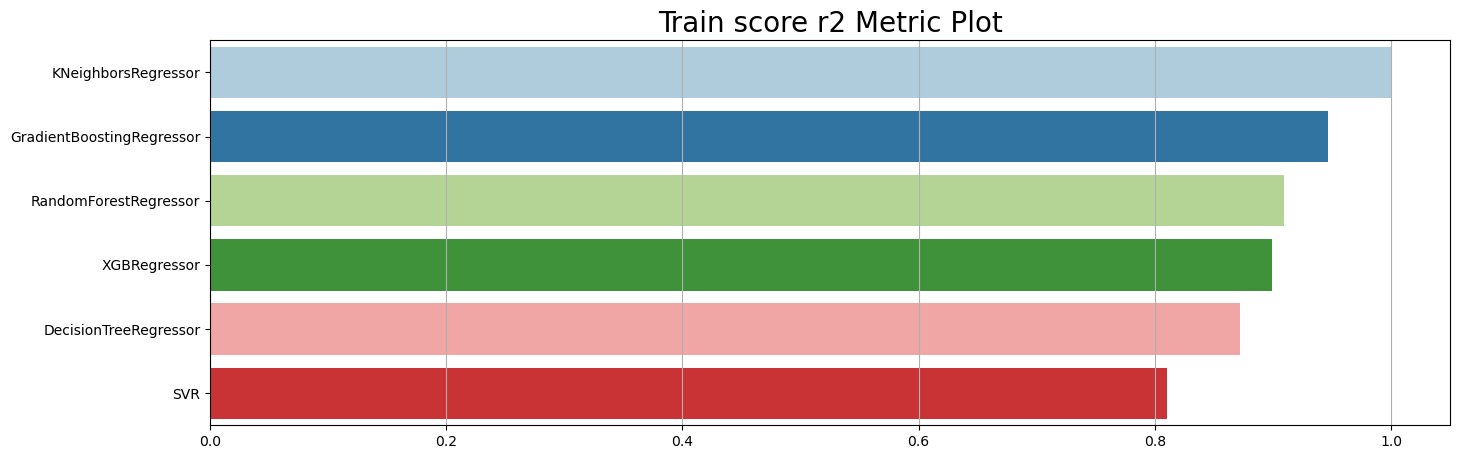

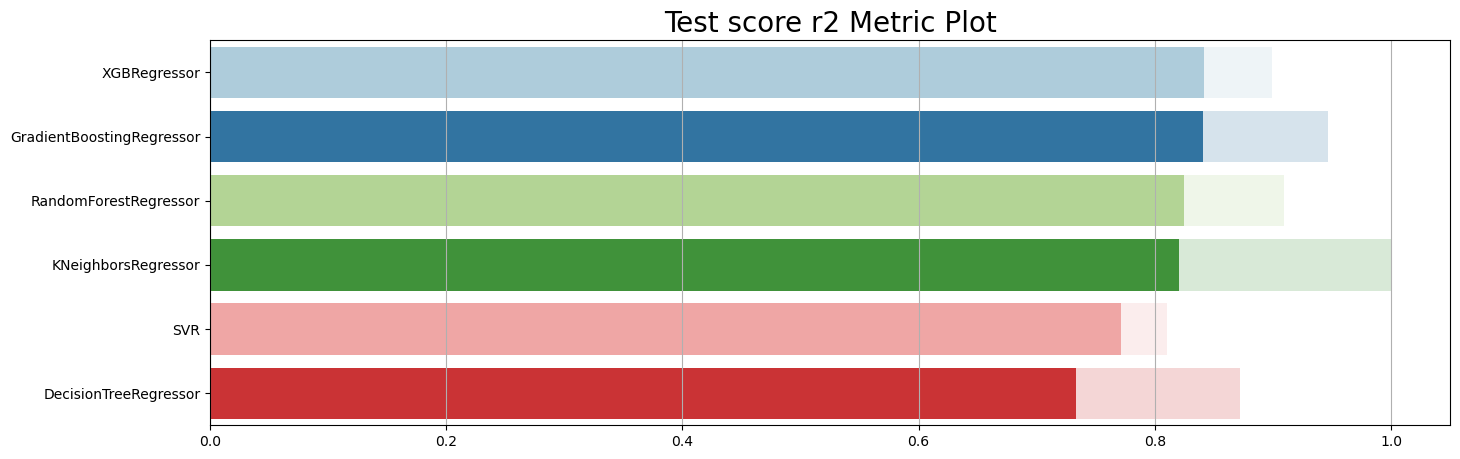

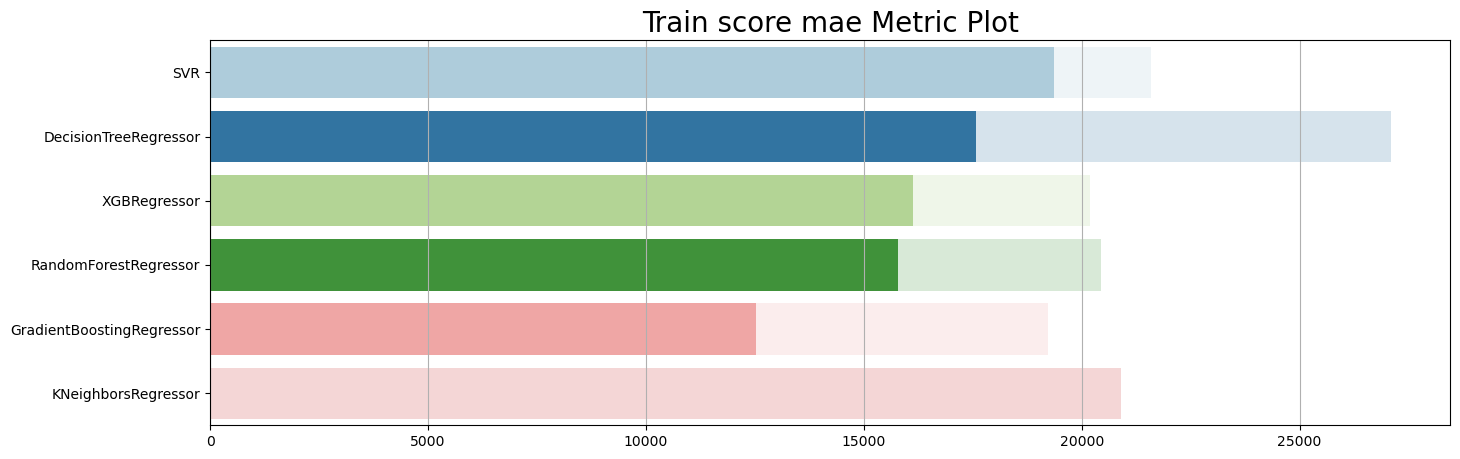

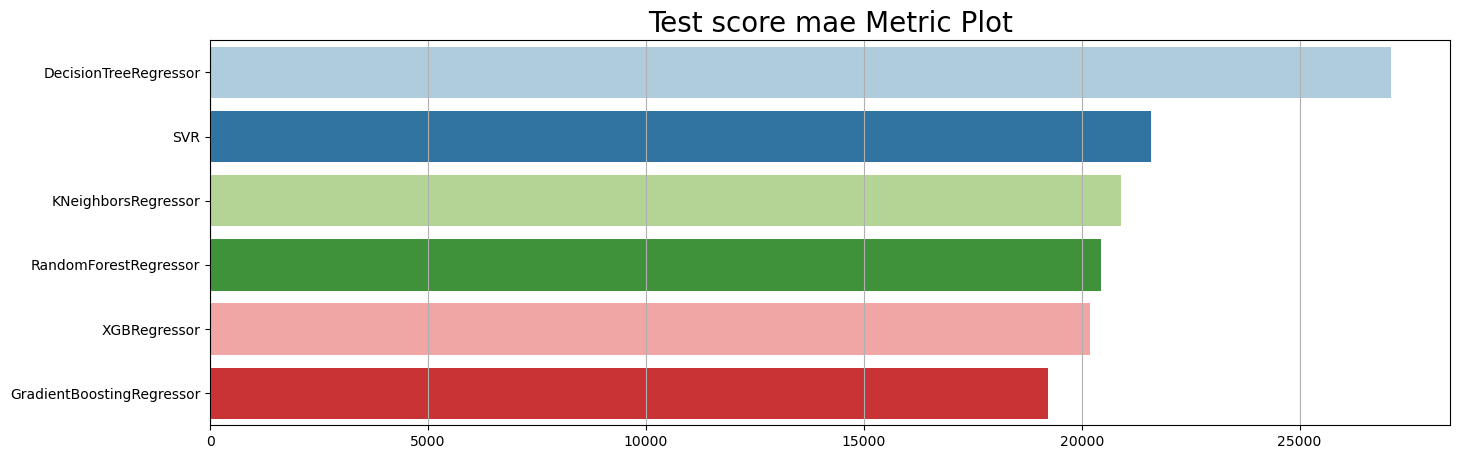

In [219]:
for metric in ['train_score_r2','test_score_r2','train_score_MAE','test_score_MAE']:
    eval_plot(evaluating_dict,metric)

- <b>Conclusion</b>
    1. The r2score metric data shows that KNeighborsRegressor is the best model for training, however, it experiences a significant overfit of 20% on the test dataset. This instability towards new data can be attributed to its nature. On the other hand, the XGBRegressor algorithm model has a more stable dataset, with a difference in evaluation between train and test being under 4%. This is considered a great outcome.
    <br><br>
    2. The MeanAbsoluteError metric records GradientBoostingRegressor as having the lowest error with an average of 19222 dollars. Although, as with other tree-based algorithms, it also experiences overfitting on the test dataset.